In [1]:
from os import system
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

import metrics
from metrics import *
from evaluation import predict_model_loo
import plots
from plots import *
import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def plot_roc(ytrue, ypred):
    sensitivies = [1]
    specificities = [0]
    
    dt=0.005
    for umbral in np.arange(dt, 1, dt):
        sensitivity_i = sensitivity(ytrue, ypred, r=umbral)
        specificity_i = specificity(ytrue, ypred, r=umbral)
        sensitivies.append(sensitivity_i)
        specificities.append(specificity_i)
        
    return specificities, sensitivies


## Metabolitos individuales

In [2]:
run_metabolitos_ind = input('Ejecutar caracteristicas indiv...?(y, n)')
if run_metabolitos_ind == 'y':
    !python 04_metabolitos_individuales.py

Ejecutar caracteristicas indiv...?(y, n)n


In [3]:
train = pd.read_csv('data_preprocess/tran.csv')
test = pd.read_csv('data_preprocess/test.csv')
Xtrain = train.drop(columns='Positivo')
ytrain = train['Positivo']

##################################
columnas_target = ['Group', 'Positivo']
columnas_sintomas = ['Fever', 'Cough', 'Headache', 'Dyspnea', 'Diarrhea',
                     'Chest tightness', 'Chills', 'Pharyngalgia', 'Myalgia', 'Arthralgia',
                     'Arthralgia', 'Rhinorrhea', 'Polypnea', 'Anosmya', 'Dysgeusia']
columnas_clinicos = ['Age', 'Sex', 'Diabetes', 'Hipertension', 'Obesity', 'Smoking']
columnas_lab = list(
    set(train.columns)
    .difference(set(columnas_target + columnas_sintomas + columnas_clinicos))
)

In [4]:
df_models_uni = pd.read_csv('out/metrics_model_selection/models_uni.csv', index_col='Unnamed: 0')
df_models_uni.head()

,SVC,RandomForestClassifier,LogisticRegression,GaussianNB,best_model,best_score
Kynurenine/Tryptophan_,0.769412,0.707059,0.500000,0.842353,GaussianNB,0.842353
Lymphocytes_(%),0.500000,0.810588,0.615294,0.637647,RandomForestClassifier,0.810588
Neutro/Linfo_Radio_NLR,0.500000,0.798824,0.518824,0.757647,RandomForestClassifier,0.798824
Kynurenine,0.500000,0.615294,0.547059,0.782353,GaussianNB,0.782353
Glucose,0.500000,0.500000,0.500000,0.771765,GaussianNB,0.771765


Text(0.5, 0, '\nExactitud balanceada')

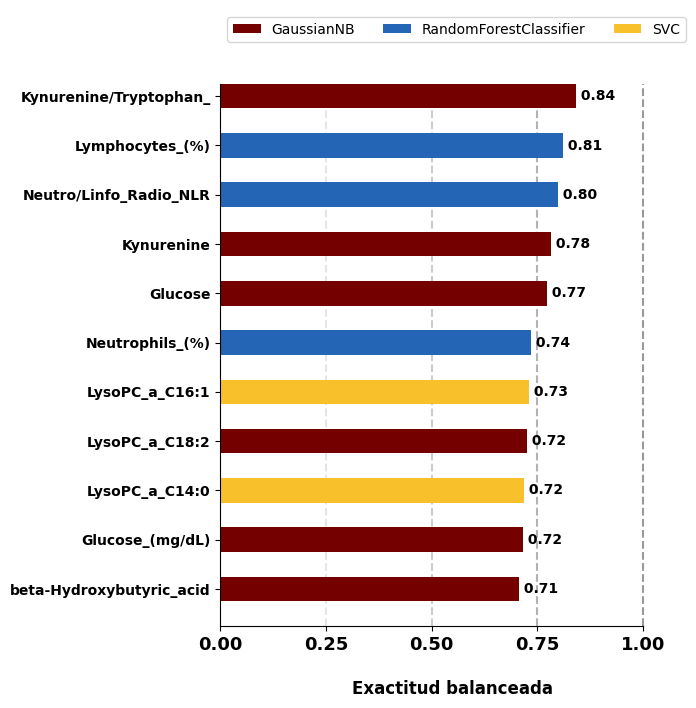

In [5]:
colors = ['#750000', '#2465b5', '#f8c12b']

fig, ax = plt.subplots(figsize=(6, 8))
best_uni_models = df_models_uni[df_models_uni.best_score>0.70]

ax.barh(best_uni_models.index, [0]*best_uni_models.shape[0], color='white')
bars = []
for model, color in zip(best_uni_models.best_model.unique(), colors):
    new_bars = ax.barh(best_uni_models[best_uni_models.best_model==model].index, 
                best_uni_models[best_uni_models.best_model==model].best_score, 
                label=f'{model}', color=color, height=0.5)

    bars = bars + list(new_bars)
    
for bar in bars:
    x = bar.get_width()
    y = bar.get_y() + 0.25
    
    ax.annotate(text=f' {x:0.2f}', xy=(x, y), ha='left', va='center', 
                fontweight='bold')

ax.legend(loc='upper left', fontsize=10, ncols=3)
ax.set_ylim(-1.75, len(best_uni_models)-0.25)
ax.set_xlim(0, 1.1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylim(reversed(ax.get_ylim()))
ax.spines[['top','right']].set_visible(False)
ax.spines['bottom'].set_bounds(0, 1)
ax.spines['left'].set_bounds(len(best_uni_models)-0.25, -0.25)

ax.vlines([0.25, 0.5, 0.75, 1], ymin=ax.get_ylim()[0], ymax=-0.25, 
          color='gray', zorder=0, alpha=[0.2, 0.4, 0.6, 0.8], ls='--')
ax.tick_params(axis='x', labelsize=13)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.set_xlabel('\nExactitud balanceada', fontsize=12, fontweight='bold')

#### Mejores modelos

In [6]:
X = train[[df_models_uni.index[0]]]
model = GaussianNB()

ytrue, ypred = predict_model_loo(model, X, ytrain)


110it [00:00, 2032.84it/s]


<Axes: xlabel='Valor predecido', ylabel='Valor real'>

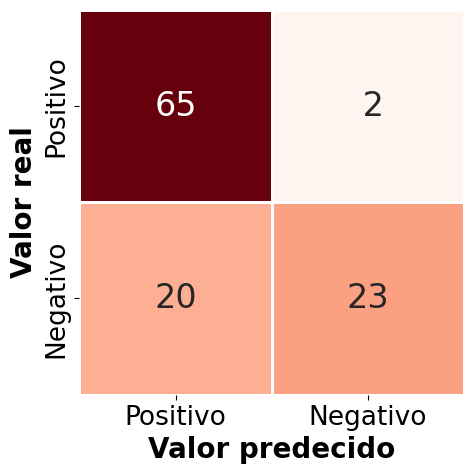

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

mat = confusion_matrix(ytrue, ypred, r=select_threshold(ytrue, ypred))
plots.plot_confusion_matrix(mat, ax=ax)

In [8]:
pd.Series(metrics.get_metrics(*mat.ravel()))

metrics_uni_train = pd.Series(metrics.get_metrics(*mat.ravel()))
metrics_uni_train['AUC'] = roc_auc_score(ytrue, ypred)
metrics_uni_train

precision      0.970149
recall         0.764706
f1             0.855263
accuracy       0.842353
specificity    0.920000
AUC            0.842353
dtype: float64

Text(0.713, 0.275, '')

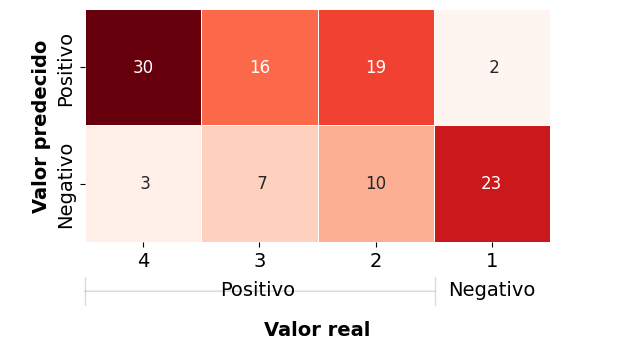

In [9]:
mat = mult_confusion_matrix(train.Group, ypred)

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(mat, square=True, annot=True, cbar=False, lw=0.5, 
            cmap='Reds', fmt='2.0f', annot_kws={'fontsize':12}, 
            yticklabels=['Positivo', 'Negativo'], 
            xticklabels=[4,3, 2, 1])
ax.tick_params(labelsize=14)
ax.set_xlabel('\n\nValor real', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor predecido', fontsize=14, fontweight='bold')

axa = fig.add_axes([0, 0.15, 1, 0.25])
axa.axis('off')
axa.annotate('Positivo', xy=(0.35, 0.25), fontsize=14)
axa.annotate('Negativo', xy=(0.73, 0.25), fontsize=14)
axa.annotate('', xy=(0.12, 0.275), xytext=(0.713, 0.275), va='center',
            arrowprops={'arrowstyle': '|-|', 'alpha':0.15})

#### Prueba ciega

In [10]:
X = train[[df_models_uni.index[0]]]
y = train['Positivo']

# Entrenamiento
model = GaussianNB()
model.fit(X, y)

# Prueba
Xtest = test[[df_models_uni.index[0]]]
ytest = test['Positivo']
ytrue = ytest.copy()
ypred = model.predict(Xtest)

<Axes: xlabel='Valor predecido', ylabel='Valor real'>

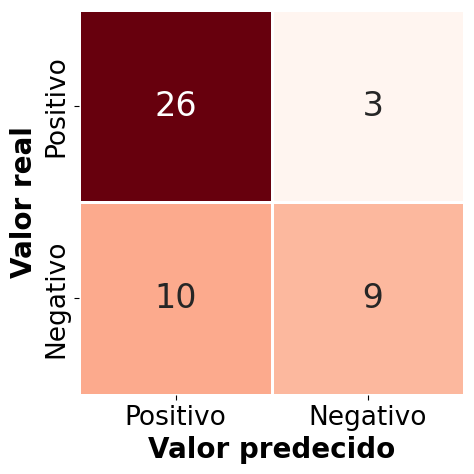

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

mat = confusion_matrix(ytrue, ypred, r=select_threshold(ytrue, ypred))
plots.plot_confusion_matrix(mat, ax=ax)

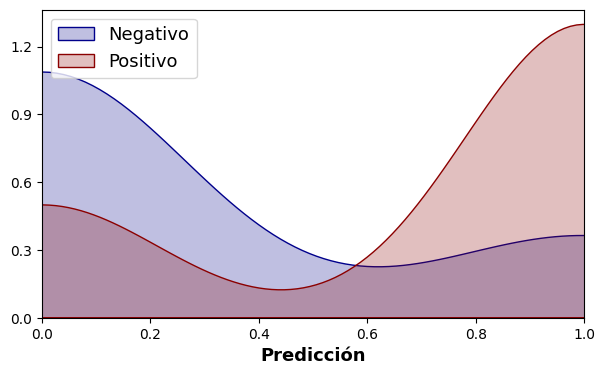

In [12]:
plots.plot_kde_predictions(ytest, ypred)

In [13]:
pd.Series(metrics.get_metrics(*mat.ravel()))

metrics_uni_blind = pd.Series(metrics.get_metrics(*mat.ravel()))
metrics_uni_blind['AUC'] = roc_auc_score(ytrue, ypred)
metrics_uni_blind

precision      0.896552
recall         0.722222
f1             0.800000
accuracy       0.736111
specificity    0.750000
AUC            0.736111
dtype: float64

Text(0.713, 0.275, '')

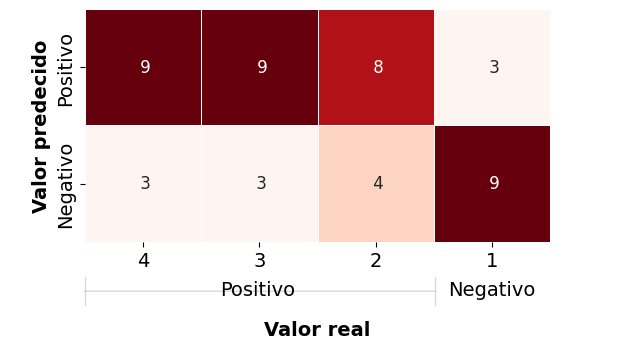

In [14]:
mat = mult_confusion_matrix(test.Group, ypred)

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(mat, square=True, annot=True, cbar=False, lw=0.5, 
            cmap='Reds', fmt='2.0f', annot_kws={'fontsize':12}, 
            yticklabels=['Positivo', 'Negativo'], 
            xticklabels=[4,3, 2, 1])
ax.tick_params(labelsize=14)
ax.set_xlabel('\n\nValor real', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor predecido', fontsize=14, fontweight='bold')

axa = fig.add_axes([0, 0.15, 1, 0.25])
axa.axis('off')
axa.annotate('Positivo', xy=(0.35, 0.25), fontsize=14)
axa.annotate('Negativo', xy=(0.73, 0.25), fontsize=14)
axa.annotate('', xy=(0.12, 0.275), xytext=(0.713, 0.275), va='center',
            arrowprops={'arrowstyle': '|-|', 'alpha':0.15})

# Modelo con varias características

### Selección de Caracteristicas

In [15]:
run_feature_selec = input('Ejecutar seleccion de caracteristicas? (y, n)')
if run_feature_selec == 'y':
    !python 02_feature_selectoin.

Ejecutar seleccion de caracteristicas? (y, n)n


In [16]:
columnas_forward = list(pd.read_csv('out/features_forward.txt', header=None, encoding='utf-8')[0])
columnas_boruta = list(pd.read_csv('out/features_boruta.txt', header=None, encoding='utf-8')[0])
columnas_ga = list(pd.read_csv('out/features_genetic.txt', header=None, encoding='utf-8')[0])
columnas_lasso = list(pd.read_csv('out/features_lasso.txt', header=None, encoding='utf-8')[0])

31


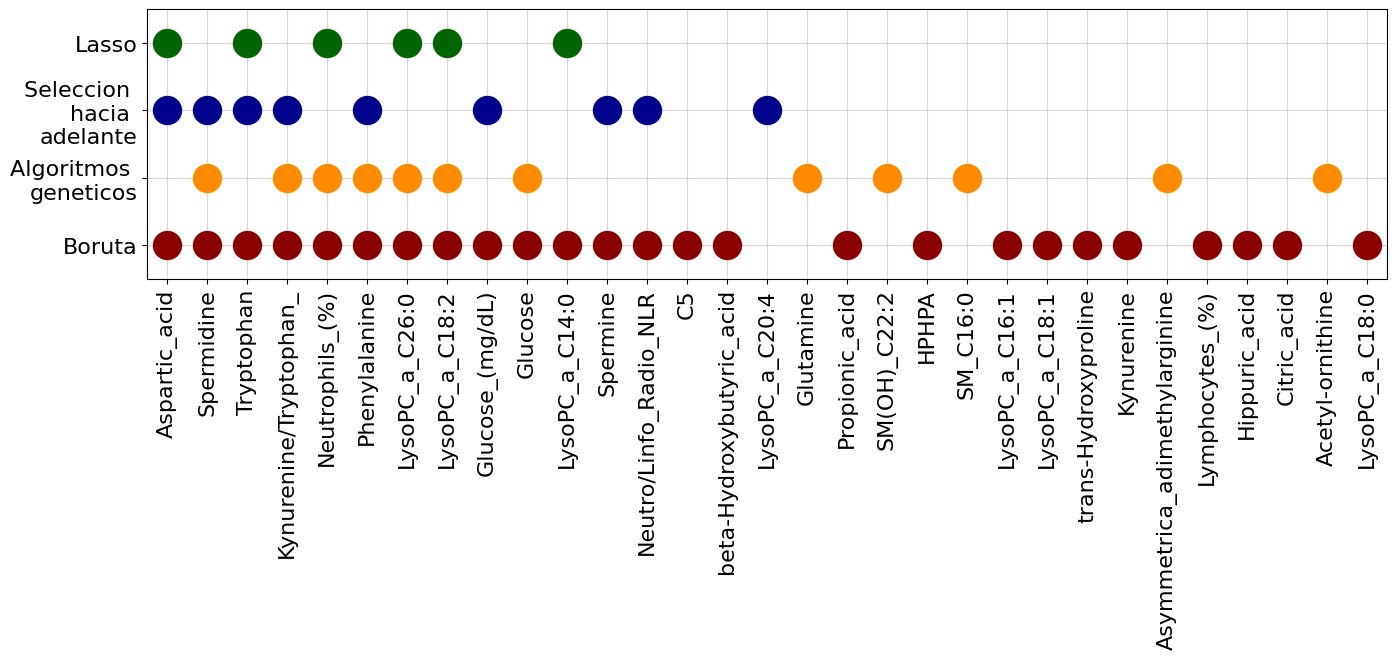

In [17]:
columnas_seleccionadas = set.union(set(columnas_forward), set(columnas_boruta), set(columnas_ga), set(columnas_lasso))
columnas_seleccionadas = list(columnas_seleccionadas)

columnas_seleccionadas = sorted(columnas_seleccionadas, key=lambda lab: -(columnas_boruta + columnas_forward + columnas_ga + columnas_lasso).count(lab))

fig, ax = plt.subplots(figsize=(16, 3.5))

ax.scatter(columnas_seleccionadas, [0]*len(columnas_seleccionadas), s=0, color='darkred')
ax.scatter(columnas_forward, [3]*len(columnas_forward), s=405, color='darkblue', zorder=2)
ax.scatter(columnas_lasso, [4]*len(columnas_lasso), s=405, zorder=2, color='darkgreen')
ax.scatter(columnas_ga, [2]*len(columnas_ga), zorder=2, s=405, color='darkorange')
ax.scatter(columnas_boruta, [1]*len(columnas_boruta), zorder=2, s=405, color='darkred')

ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels([ 'Boruta','Algoritmos \ngeneticos', 'Seleccion \nhacia \nadelante', 'Lasso'])
ax.set_ylim(0.5, 4.5)

ax.tick_params(axis='x', rotation=90)
ax.grid(zorder=0, alpha=0.5)

ax.set_xlim(-0.5, len(columnas_seleccionadas)-0.5)
ax.tick_params(labelsize=16)

plt.savefig('metabolitos_seleccionados.pdf', bbox_inches='tight')

print(len(columnas_seleccionadas))

### Selección del modelo

In [18]:
run_model_selec = input('Ejecutar seleccion de modelo (y, n)')
if run_model_selec == 'y':
    !python 03_model_selection.py

Ejecutar seleccion de modelo (y, n)n


In [19]:
balanced_accuracies = pd.read_csv('out/metrics_model_selection/balanced_accuracies.csv',
                                 index_col='Unnamed: 0')
f1_scores = pd.read_csv('out/metrics_model_selection/auc_scores.csv',
                       index_col='Unnamed: 0')
aucs = pd.read_csv('out/metrics_model_selection/auc_scores.csv',
                  index_col='Unnamed: 0')
precisions = pd.read_csv('out/metrics_model_selection/precisions.csv',
                        index_col='Unnamed: 0')
recalls = pd.read_csv('out/metrics_model_selection/recalls.csv',
                     index_col='Unnamed: 0')
specificities = pd.read_csv('out/metrics_model_selection/specificities.csv',
                           index_col='Unnamed: 0')


Text(0.9129411764705884, 3.5, '0.913')

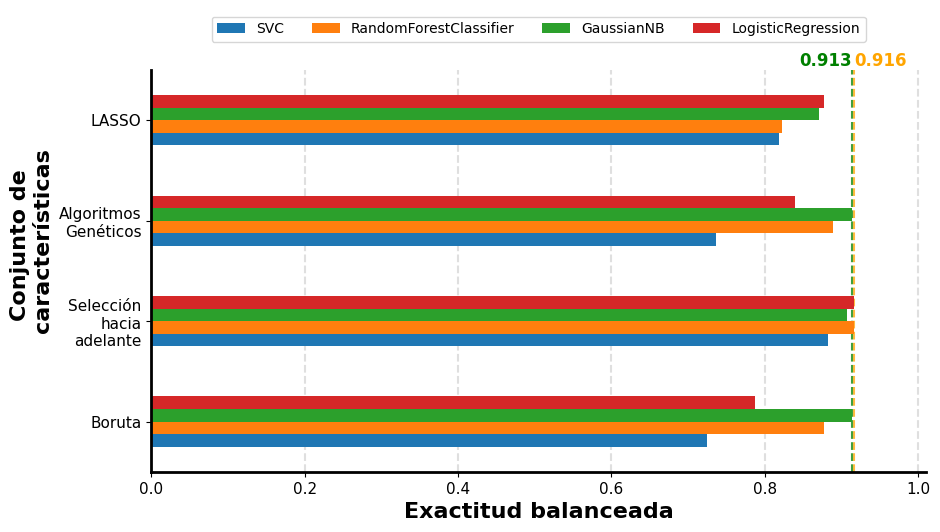

In [20]:
max_balanced_accuracy_RF = max(balanced_accuracies.T['RandomForestClassifier'])
max_balanced_accuracy_GNB = max(balanced_accuracies.T['GaussianNB'])
fig, ax = plt.subplots(figsize=(10, 6))
balanced_accuracies.T.plot.barh(ax=ax, zorder=3)

ax.set_xlim(0, 1.01)
ax.set_ylim(-0.5, 4.1)
ax.set_yticklabels(['Boruta', 'Selección\nhacia\nadelante', 
                    'Algoritmos\nGenéticos', 'LASSO'])
ax.legend(ncols=4, loc='upper center')
ax.tick_params(labelsize=11)

ax.set_xlabel('Exactitud balanceada', fontweight='bold', fontsize=16)
ax.set_ylabel('Conjunto de \ncaracterísticas', fontweight='bold', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set(lw=2, zorder=5)
ax.spines['left'].set(lw=2, zorder=5, bounds=(-0.5, 3.5))



ax.vlines(x=ax.get_xticks(), ymin=-0.5, ymax=3.5, color='gray', linestyle='--', 
          alpha=0.25)

ax.vlines(x=max_balanced_accuracy_RF, ymin=-0.5, ymax=3.5, 
          color='orange', alpha=0.75, linestyle='--')
ax.vlines(x=max_balanced_accuracy_GNB, ymin=-0.5, ymax=3.5, 
          color='green', alpha=0.75, linestyle='--')
ax.annotate(text=f'{max_balanced_accuracy_RF:0.3f}', xy=(max_balanced_accuracy_RF, 3.5), 
            va='bottom', ha='left', color='orange', fontweight='bold', fontsize=12)
ax.annotate(text=f'{max_balanced_accuracy_GNB:0.3f}', xy=(max_balanced_accuracy_GNB, 3.5), 
            va='bottom', ha='right', color='green', fontweight='bold', fontsize=12)

Text(0.9698823529411764, 3.5, '0.970')

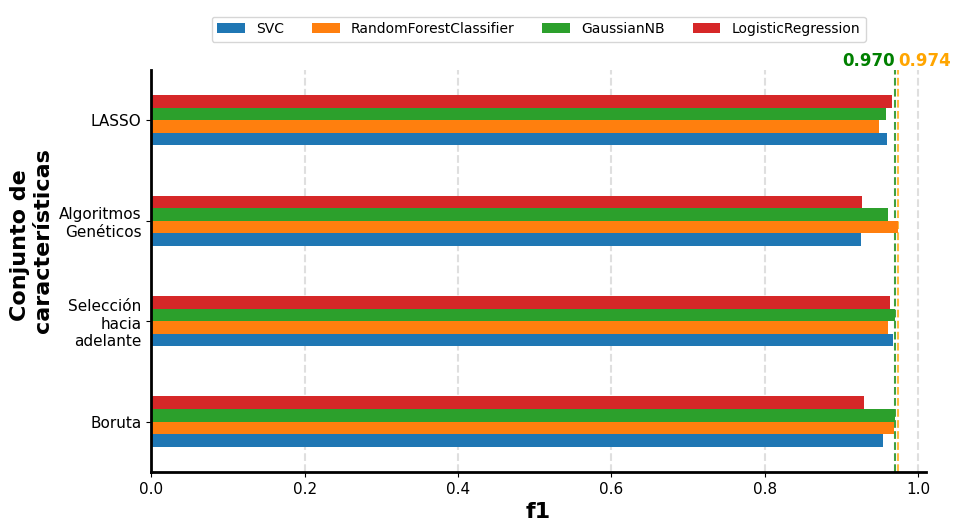

In [21]:
max_f1_RF = max(f1_scores.T['RandomForestClassifier'])
max_f1_GNB = max(f1_scores.T['GaussianNB'])
fig, ax = plt.subplots(figsize=(10, 6))
f1_scores.T.plot.barh(ax=ax, zorder=3)

ax.set_xlim(0, 1.01)
ax.set_ylim(-0.5, 4.1)
ax.set_yticklabels(['Boruta', 'Selección\nhacia\nadelante', 
                    'Algoritmos\nGenéticos', 'LASSO'])
ax.legend(ncols=4, loc='upper center')
ax.tick_params(labelsize=11)

ax.set_xlabel('f1', fontweight='bold', fontsize=16)
ax.set_ylabel('Conjunto de \ncaracterísticas', fontweight='bold', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set(lw=2, zorder=5)
ax.spines['left'].set(lw=2, zorder=5, bounds=(-0.5, 3.5))



ax.vlines(x=ax.get_xticks(), ymin=-0.5, ymax=3.5, color='gray', linestyle='--', 
          alpha=0.25)

ax.vlines(x=max_f1_RF, ymin=-0.5, ymax=3.5, 
          color='orange', alpha=0.75, linestyle='--')
ax.vlines(x=max_f1_GNB, ymin=-0.5, ymax=3.5, 
          color='green', alpha=0.75, linestyle='--')
ax.annotate(text=f'{max_f1_RF:0.3f}', xy=(max_f1_RF, 3.5), 
            va='bottom', ha='left', color='orange', fontweight='bold', fontsize=12)
ax.annotate(text=f'{max_f1_GNB:0.3f}', xy=(max_f1_GNB, 3.5), 
            va='bottom', ha='right', color='green', fontweight='bold', fontsize=12)

Text(0.9698823529411764, 3.5, '0.970')

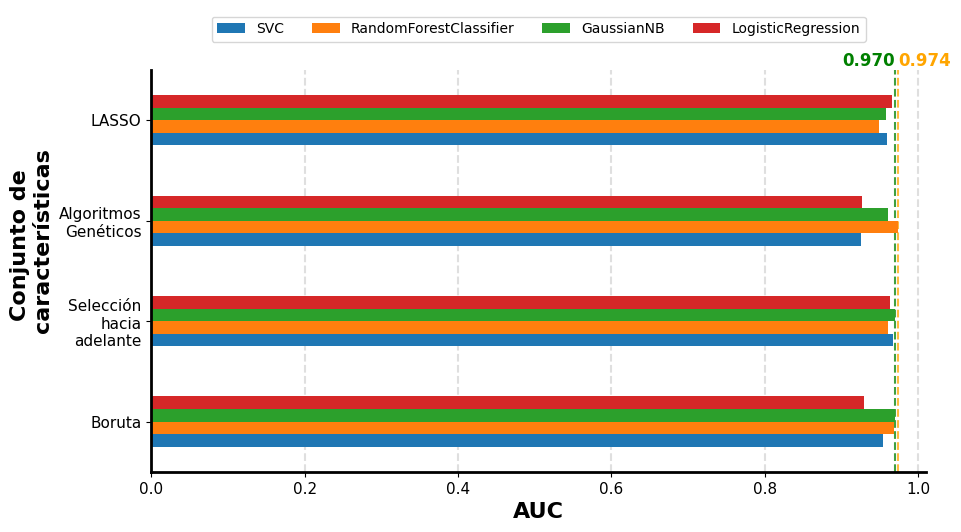

In [22]:
max_auc_RF = max(aucs.T['RandomForestClassifier'])
max_auc_GNB = max(aucs.T['GaussianNB'])
fig, ax = plt.subplots(figsize=(10, 6))
aucs.T.plot.barh(ax=ax, zorder=3)

ax.set_xlim(0, 1.01)
ax.set_ylim(-0.5, 4.1)
ax.set_yticklabels(['Boruta', 'Selección\nhacia\nadelante', 
                    'Algoritmos\nGenéticos', 'LASSO'])
ax.legend(ncols=4, loc='upper center')
ax.tick_params(labelsize=11)

ax.set_xlabel('AUC', fontweight='bold', fontsize=16)
ax.set_ylabel('Conjunto de \ncaracterísticas', fontweight='bold', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set(lw=2, zorder=5)
ax.spines['left'].set(lw=2, zorder=5, bounds=(-0.5, 3.5))



ax.vlines(x=ax.get_xticks(), ymin=-0.5, ymax=3.5, color='gray', linestyle='--', 
          alpha=0.25)

ax.vlines(x=max_auc_RF, ymin=-0.5, ymax=3.5, 
          color='orange', alpha=0.75, linestyle='--')
ax.vlines(x=max_auc_GNB, ymin=-0.5, ymax=3.5, 
          color='green', alpha=0.75, linestyle='--')
ax.annotate(text=f'{max_auc_RF:0.3f}', xy=(max_auc_RF, 3.5), 
            va='bottom', ha='left', color='orange', fontweight='bold', fontsize=12)
ax.annotate(text=f'{max_auc_GNB:0.3f}', xy=(max_auc_GNB, 3.5), 
            va='bottom', ha='right', color='green', fontweight='bold', fontsize=12)

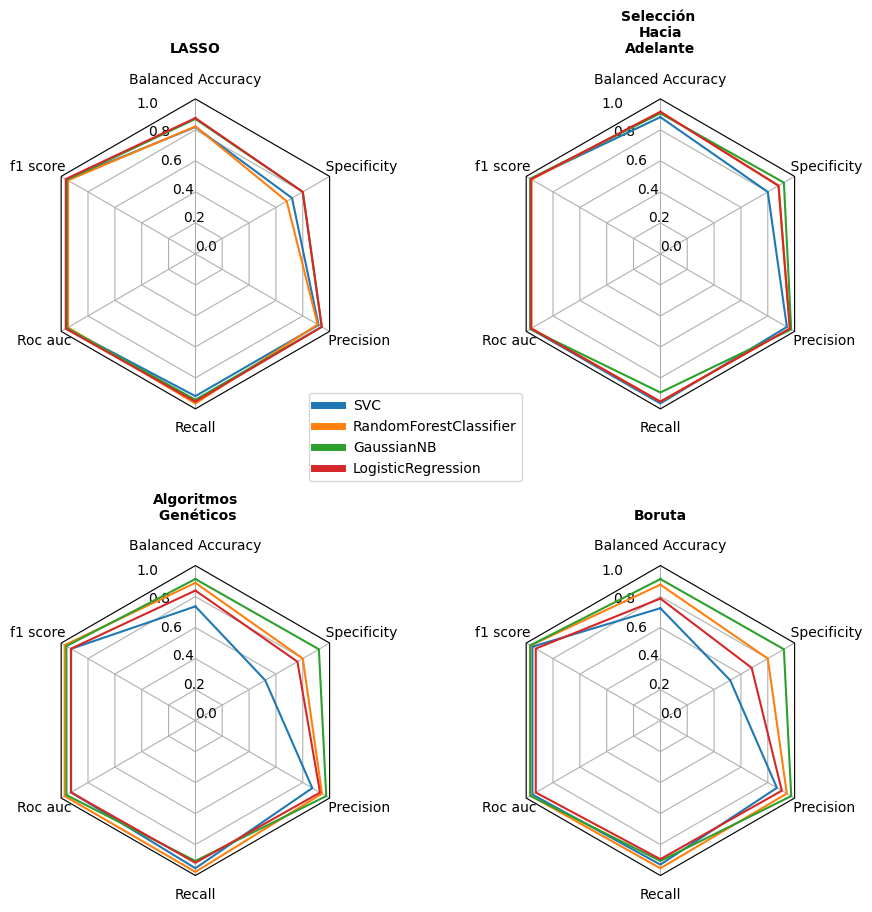

In [23]:
model_metrics = [balanced_accuracies, f1_scores, aucs, 
                 recalls, precisions, specificities]
data = [
        ['Balanced Accuracy','f1 score   ','Roc auc',
         'Recall', '      Precision', '       Specificity'],
        ('LASSO\n', [
            [m['lasso']['SVC'] for m in model_metrics], 
            [m['lasso']['RandomForestClassifier'] for m in model_metrics],
            [m['lasso']['GaussianNB'] for m in model_metrics],
            [m['lasso']['LogisticRegression'] for m in model_metrics]
        ]),
        ('Selección \nHacia\nAdelante\n', [
            [m['forward']['SVC'] for m in model_metrics], 
            [m['forward']['RandomForestClassifier'] for m in model_metrics],
            [m['forward']['GaussianNB'] for m in model_metrics],
            [m['forward']['LogisticRegression'] for m in model_metrics]
        ]),
        ('Algoritmos\n Genéticos\n', [
            [m['genetic']['SVC'] for m in model_metrics], 
            [m['genetic']['RandomForestClassifier'] for m in model_metrics],
            [m['genetic']['GaussianNB'] for m in model_metrics],
            [m['genetic']['LogisticRegression'] for m in model_metrics]
        ]),
        ('Boruta\n', [
            [m['boruta']['SVC'] for m in model_metrics], 
            [m['boruta']['RandomForestClassifier'] for m in model_metrics],
            [m['boruta']['GaussianNB'] for m in model_metrics],
            [m['boruta']['LogisticRegression'] for m in model_metrics]
        ]),
    ]

if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    ax_legend = fig.add_axes([0.2, 0.2, 0.6, 0.6])
    ax_legend.axis('off')
    ax_legend.plot([], [], label='SVC', color='C0', lw=5)
    ax_legend.plot([], [], label='RandomForestClassifier', color='C1', lw=5)
    ax_legend.plot([], [], label='GaussianNB', color='C2', lw=5)
    ax_legend.plot([], [], label='LogisticRegression', color='C3', lw=5)
    ax_legend.legend(loc='center', fontsize=10)
    
    fig.subplots_adjust(wspace=0.5, hspace=0.40, top=0.85, bottom=0.05)

    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_ylim(0.5, 1)
        ax.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
#            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('SVC', 'RandomForestClassifier', 'GaussianNB', 'LogisticRegression',)
    #legend = axs[1, 0].legend(labels, loc=(0.9, .95),
    #                          labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

In [24]:

with open('out/best_model/best_model.pkl', 'rb') as f:
    best_model_multi = pickle.load(f)
    
best_model = best_model_multi


In [25]:
best_model

{'model': sklearn.ensemble._forest.RandomForestClassifier,
 'model_params': {'bootstrap': True, 'max_depth': 11, 'n_estimators': 100},
 'features': ['Neutro/Linfo_Radio_NLR',
  'Kynurenine/Tryptophan_',
  'LysoPC_a_C20:4',
  'Glucose_(mg/dL)',
  'Spermine',
  'Spermidine',
  'Phenylalanine',
  'Tryptophan',
  'Aspartic_acid']}

### LOOCV en Conjunto de Prueba

In [26]:
model = best_model['model'](**best_model['model_params'])

Xtrain = train[best_model['features']]
ytrain = ytrain

ytrue, ypred = predict_model_loo(model, Xtrain, ytrain, proba=True)

110it [00:09, 11.26it/s]


In [27]:
ypred

[0.73,
 0.11,
 0.41,
 0.25,
 0.11,
 0.39,
 0.42,
 0.24,
 0.14,
 0.31,
 0.48,
 0.07,
 0.32,
 0.35,
 0.3,
 0.29,
 0.48,
 0.3,
 0.36,
 0.9,
 0.48,
 0.23,
 0.49,
 0.52,
 0.44,
 1.0,
 0.92,
 0.61,
 0.83,
 0.89,
 0.98,
 0.8,
 0.74,
 0.92,
 0.87,
 0.25,
 0.78,
 0.27,
 0.59,
 0.92,
 0.93,
 0.94,
 0.94,
 0.99,
 0.95,
 1.0,
 0.92,
 1.0,
 0.98,
 0.8,
 0.95,
 0.96,
 0.55,
 0.75,
 0.9,
 1.0,
 0.95,
 0.82,
 0.78,
 0.98,
 0.72,
 0.67,
 0.99,
 1.0,
 0.93,
 0.97,
 0.98,
 0.83,
 1.0,
 1.0,
 0.49,
 0.96,
 0.98,
 1.0,
 1.0,
 0.97,
 0.88,
 1.0,
 1.0,
 0.75,
 1.0,
 0.99,
 0.61,
 1.0,
 1.0,
 1.0,
 0.99,
 0.95,
 0.97,
 0.98,
 1.0,
 1.0,
 0.97,
 0.95,
 0.94,
 0.95,
 1.0,
 1.0,
 0.87,
 1.0,
 1.0,
 0.99,
 0.86,
 1.0,
 1.0,
 0.99,
 1.0,
 1.0,
 1.0,
 0.93]

<Axes: xlabel='Valor predecido', ylabel='Valor real'>

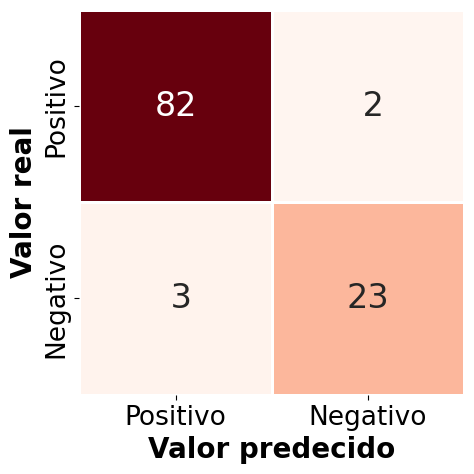

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))

mat = confusion_matrix(ytrue, ypred, r=select_threshold(ytrue, ypred))
plots.plot_confusion_matrix(mat, ax=ax)

In [29]:
metrics_multi_train = pd.Series(metrics.get_metrics(*mat.ravel()))
metrics_multi_train['AUC'] = roc_auc_score(ytrue, ypred)
metrics_multi_train

precision      0.976190
recall         0.964706
f1             0.970414
accuracy       0.942353
specificity    0.920000
AUC            0.968235
dtype: float64

Text(0.713, 0.275, '')

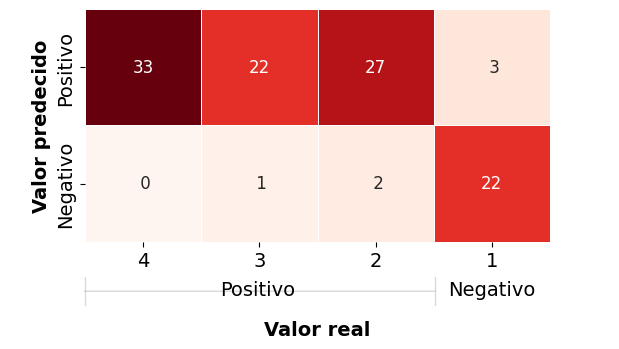

In [30]:
mat = mult_confusion_matrix(train.Group, ypred)

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(mat, square=True, annot=True, cbar=False, lw=0.5, 
            cmap='Reds', fmt='2.0f', annot_kws={'fontsize':12}, 
            yticklabels=['Positivo', 'Negativo'], 
            xticklabels=[4,3, 2, 1])
ax.tick_params(labelsize=14)
ax.set_xlabel('\n\nValor real', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor predecido', fontsize=14, fontweight='bold')

axa = fig.add_axes([0, 0.15, 1, 0.25])
axa.axis('off')
axa.annotate('Positivo', xy=(0.35, 0.25), fontsize=14)
axa.annotate('Negativo', xy=(0.73, 0.25), fontsize=14)
axa.annotate('', xy=(0.12, 0.275), xytext=(0.713, 0.275), va='center',
            arrowprops={'arrowstyle': '|-|', 'alpha':0.15})

In [31]:
ytrue_train = ytrue.copy()
ypred_train = ypred.copy()

### Prueba Ciega

In [32]:
Xtrain = pd.read_csv('data_preprocess/tran.csv')[best_model['features']]
ytrain = pd.read_csv('data_preprocess/tran.csv')['Positivo']
Xtest = pd.read_csv('data_preprocess/test.csv')[best_model['features']]
ytest = pd.read_csv('data_preprocess/test.csv')['Positivo']

In [33]:
model = best_model['model'](**best_model['model_params'])
model.fit(Xtrain, ytrain)

ypred = model.predict_proba(Xtest)[:, 1]

<Axes: xlabel='Valor predecido', ylabel='Valor real'>

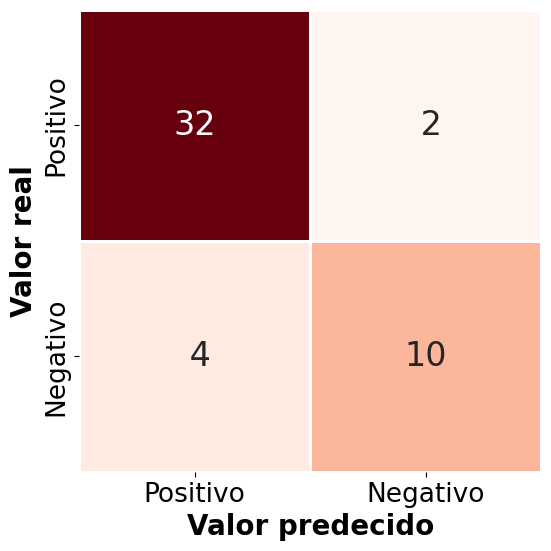

In [34]:
ytrue = ytest.copy()

mat = metrics.confusion_matrix(ytrue, ypred, r=plots.select_threshold(ytrue, ypred))
plots.plot_confusion_matrix(mat)

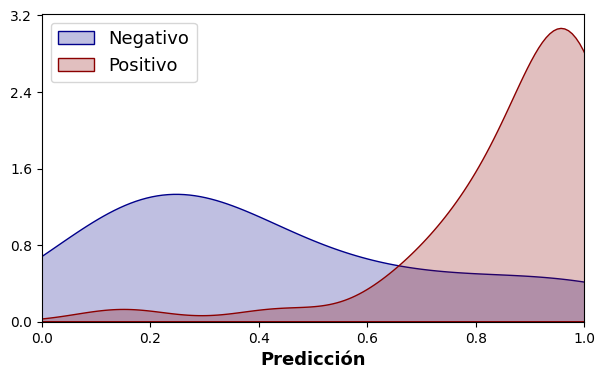

In [35]:
plots.plot_kde_predictions(ytest, ypred)

In [36]:
from sklearn.metrics import roc_auc_score, auc

metrics_multi_blind = pd.Series(metrics.get_metrics(*mat.ravel()))
metrics_multi_blind['AUC'] = roc_auc_score(ytrue, ypred)
metrics_multi_blind

precision      0.941176
recall         0.888889
f1             0.914286
accuracy       0.861111
specificity    0.833333
AUC            0.862269
dtype: float64

In [37]:
ytrue_blind = ytrue.copy()
ypred_blind = ypred.copy()

#### Prueba ciega

[[<matplotlib.axis.XTick at 0x21b1f3d6750>,

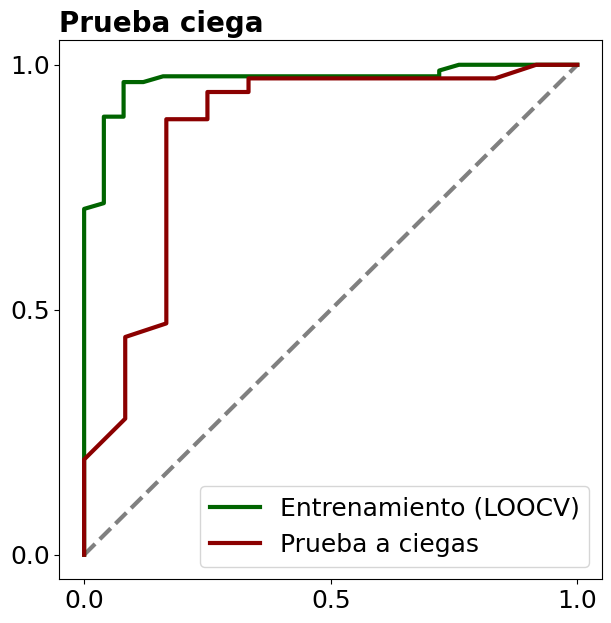

In [38]:

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot([0, 1], [0, 1], color='gray', lw=3, ls='--')

# Train curve
specificities, sensitivies = plot_roc(ytrue_train, ypred_train)
x = [1 - spec_i for spec_i in specificities] + [0]
y = sensitivies + [0]
ax.plot(x, y, color='darkgreen', lw=3, label='Entrenamiento (LOOCV)')

# Test curve
specificities, sensitivies = plot_roc(ytrue, ypred)
x = [1 - spec_i for spec_i in specificities] + [0]
y = sensitivies + [0]
ax.plot(x, y, color='darkred', lw=3, label='Prueba a ciegas')

# Ticks, legend and title
ax.tick_params(labelsize=18)
ax.legend(loc='lower right', fontsize=18)
ax.set_title('Prueba ciega', fontsize=20, fontweight='bold', loc='left')

ax.set(xticks=[0, 0.5, 1], yticks=[0, 0.5, 1])

## Pronóstico

### Conjunto de prueba

In [39]:
Xtrain = train[train.Group>1][best_model['features']]
ytrain = train[train.Group>1].Group.ne(2).astype(int)

Xtest = test[test.Group>1][best_model['features']]
ytest = test[test.Group>1].Group.ne(2).astype(int)

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [40]:
model = best_model['model'](**best_model['model_params'])
ytrue_train, ypred_train = predict_model_loo(model, Xtrain, ytrain, proba=True)

85it [00:07, 11.17it/s]


<Axes: xlabel='Valor predecido', ylabel='Valor real'>

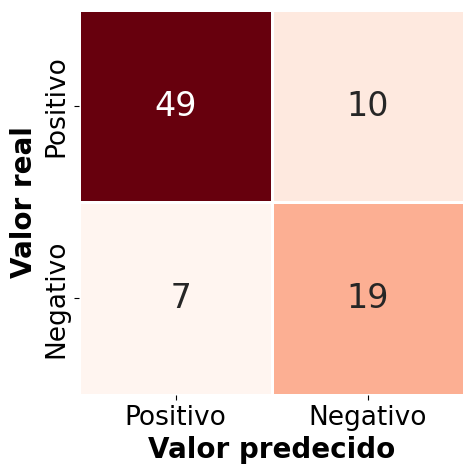

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))

mat = confusion_matrix(ytrue_train, ypred_train)
plots.plot_confusion_matrix(mat, ax=ax)

In [42]:
metrics_pron_train = pd.Series(metrics.get_metrics(*mat.ravel()))
metrics_pron_train['AUC'] = roc_auc_score(ytrue, ypred)
metrics_pron_train

precision      0.830508
recall         0.875000
f1             0.852174
accuracy       0.765086
specificity    0.655172
AUC            0.862269
dtype: float64

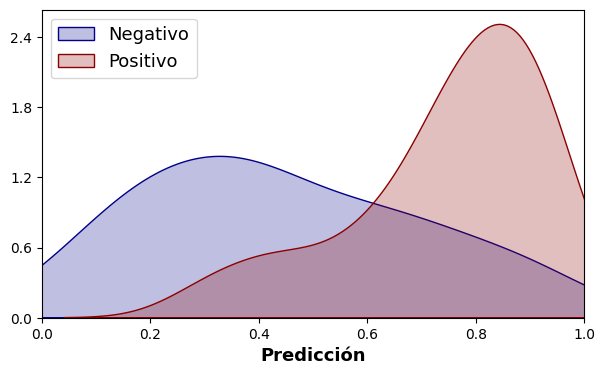

In [43]:
plots.plot_kde_predictions(ytrue_train, ypred_train)

In [44]:
model.fit(Xtrain, ytrain)

ytrue_blind = ytest.copy()
ypred_blind = model.predict_proba(Xtest)[:, 1]

<Axes: xlabel='Valor predecido', ylabel='Valor real'>

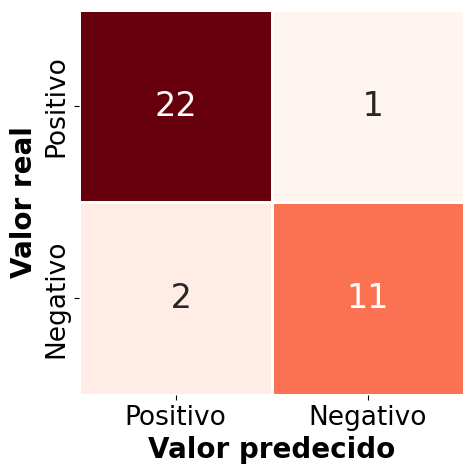

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))

mat = confusion_matrix(ytrue_blind, ypred_blind, r=0.5)
plots.plot_confusion_matrix(mat, ax=ax)

In [46]:
metrics_multi_blind = pd.Series(metrics.get_metrics(*mat.ravel()))
metrics_multi_blind['AUC'] = roc_auc_score(ytrue_blind, ypred_blind)
metrics_multi_blind

precision      0.956522
recall         0.916667
f1             0.936170
accuracy       0.916667
specificity    0.916667
AUC            0.927083
dtype: float64

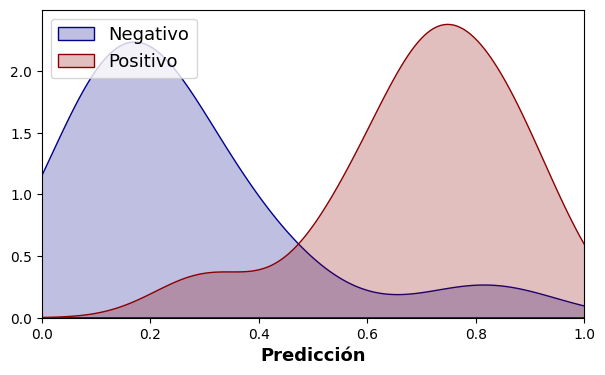

In [47]:
plots.plot_kde_predictions(ytrue_blind, ypred_blind)

[[<matplotlib.axis.XTick at 0x21b1f9aae10>,

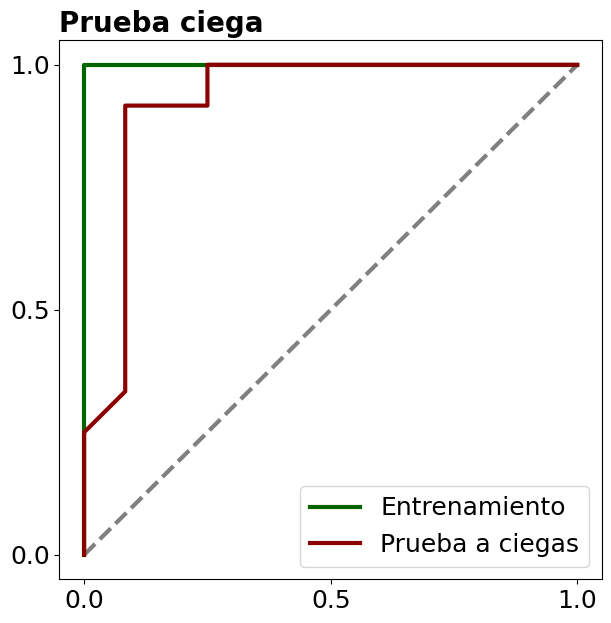

In [48]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot([0, 1], [0, 1], color='gray', lw=3, ls='--')

ytrue_train = ytrain
ypred_train = model.predict(Xtrain)

# Train curve
specificities, sensitivies = plot_roc(ytrue_train, ypred_train)
x = [1 - spec_i for spec_i in specificities] + [0]
y = sensitivies + [0]
ax.plot(x, y, color='darkgreen', lw=3, label='Entrenamiento')

# Test curve
specificities, sensitivies = plot_roc(ytrue_blind, ypred_blind)
x = [1 - spec_i for spec_i in specificities] + [0]
y = sensitivies + [0]
ax.plot(x, y, color='darkred', lw=3, label='Prueba a ciegas')

# Ticks, legend and title
ax.tick_params(labelsize=18)
ax.legend(loc='lower right', fontsize=18)
ax.set_title('Prueba ciega', fontsize=20, fontweight='bold', loc='left')

ax.set(xticks=[0, 0.5, 1], yticks=[0, 0.5, 1])